In [1]:
print("shree ram")

shree ram


In [2]:

import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers,models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Model

from pathlib import Path
import os.path
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')


from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
import urllib.request

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
filename = 'helper_functions.py'

urllib.request.urlretrieve(url, filename)

('helper_functions.py', <http.client.HTTPMessage at 0x1f01317d150>)

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:

dataset = "C:/Minor Project-Research 1/bone fracture/mammals"
walk_through_dir(dataset);

There are 52 directories and 1 images in 'C:/Minor Project-Research 1/bone fracture/mammals'.
There are 0 directories and 0 images in 'C:/Minor Project-Research 1/bone fracture/mammals\.ipynb_checkpoints'.
There are 0 directories and 347 images in 'C:/Minor Project-Research 1/bone fracture/mammals\african_elephant'.
There are 0 directories and 333 images in 'C:/Minor Project-Research 1/bone fracture/mammals\alpaca'.
There are 0 directories and 343 images in 'C:/Minor Project-Research 1/bone fracture/mammals\american_bison'.
There are 0 directories and 299 images in 'C:/Minor Project-Research 1/bone fracture/mammals\anteater'.
There are 0 directories and 315 images in 'C:/Minor Project-Research 1/bone fracture/mammals\arctic_fox'.
There are 0 directories and 331 images in 'C:/Minor Project-Research 1/bone fracture/mammals\armadillo'.
There are 0 directories and 330 images in 'C:/Minor Project-Research 1/bone fracture/mammals\baboon'.
There are 0 directories and 310 images in 'C:/Minor P

In [8]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_27264\994582165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


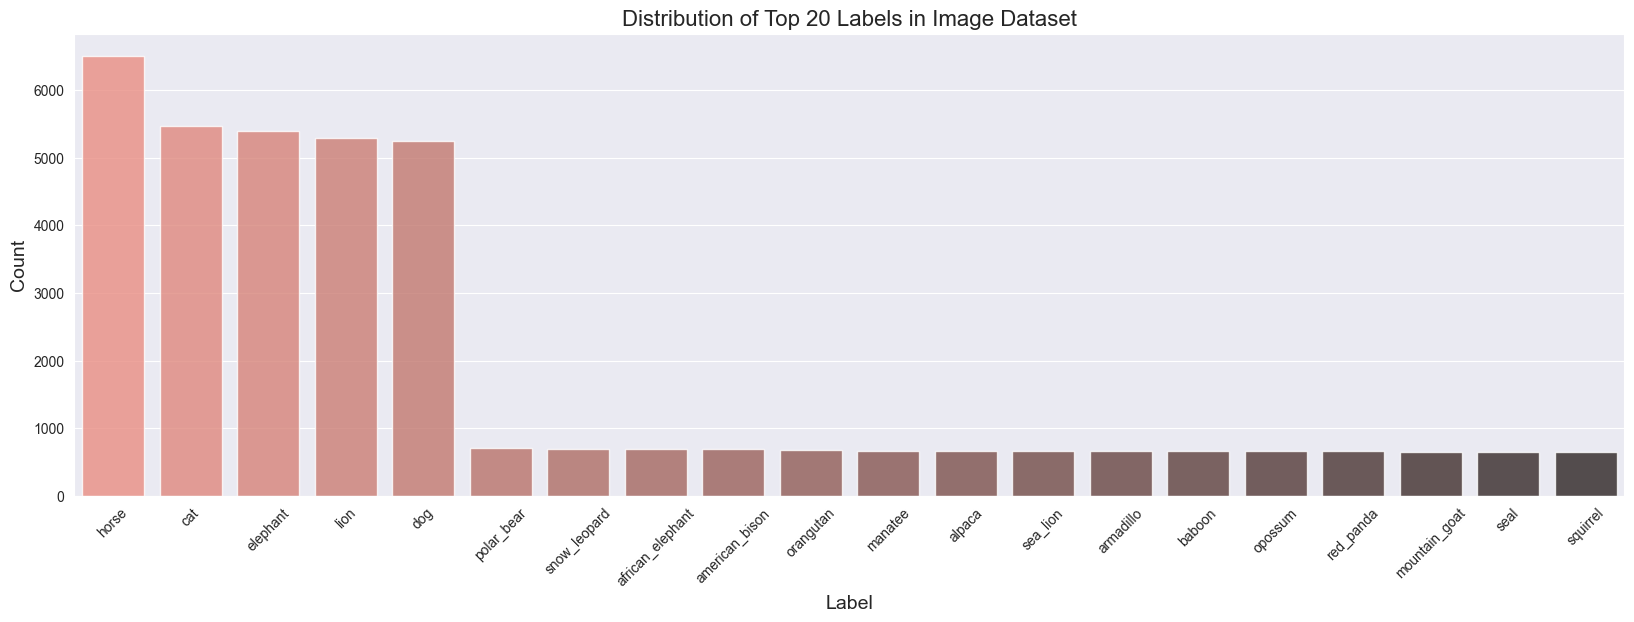

In [9]:
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

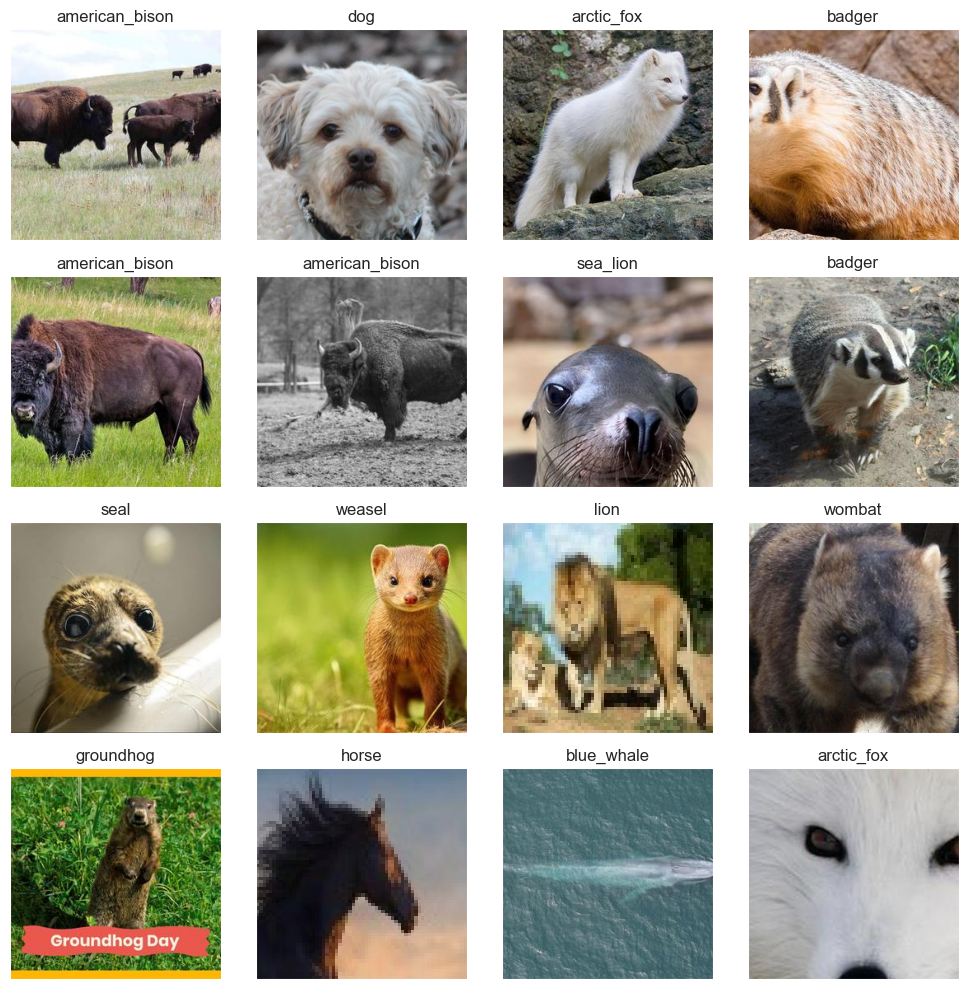

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [11]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

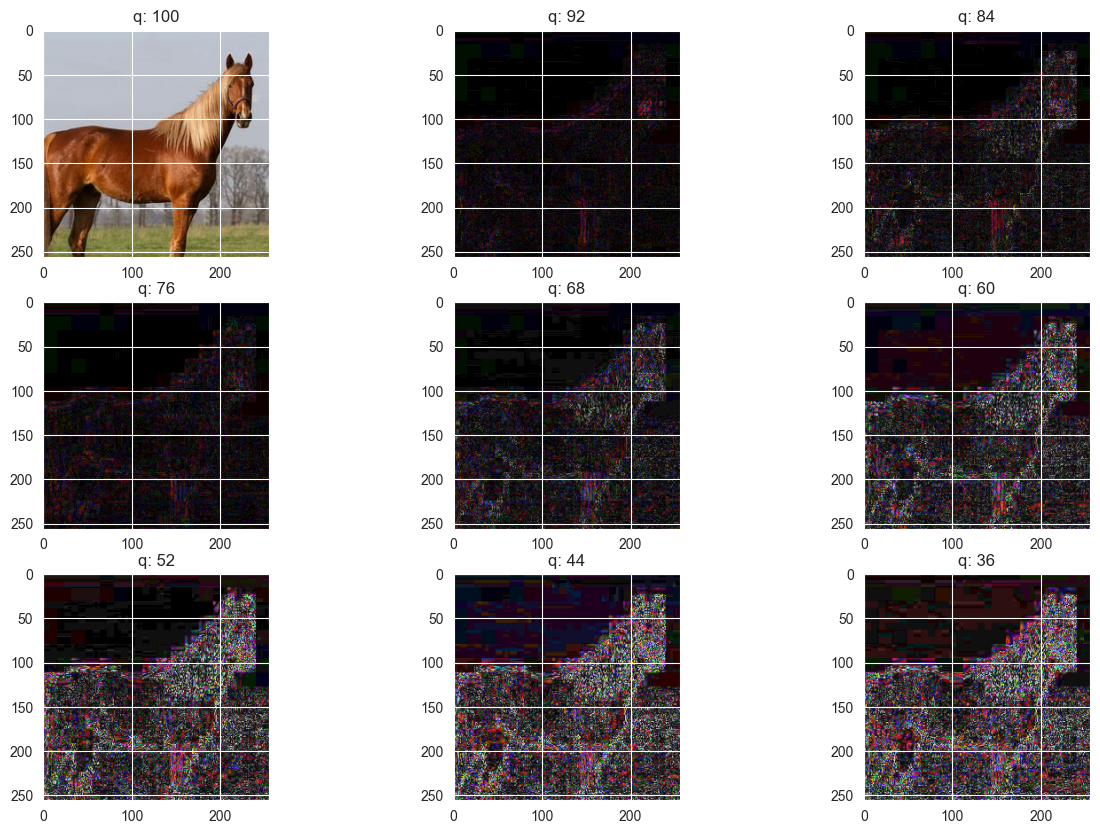

In [12]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Set the directory containing images
dir_path = 'C:\Minor Project-Research 1/bone fracture\horse'
image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png'))]

# Choose a random image path
p = random.choice(image_files)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# ELA parameters
init_val = 100
columns = 3
rows = 3

# Plotting
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    validation_split=0.2  
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'  
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,  
    seed=42,
    subset='validation'  # Validation subset
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 34732 validated image filenames belonging to 49 classes.
Found 8682 validated image filenames belonging to 49 classes.
Found 10854 validated image filenames belonging to 49 classes.


In [16]:
import tensorflow as tf
from tensorflow.keras import layers

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load the pretrained DenseNet121 model
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze the pretrained model's layers
pretrained_model.trainable = False


In [17]:

# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5" # Add .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [18]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [19]:
!nvidia-smi

Sun Dec 15 18:20:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              6W /   75W |    1835MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


# Change the output layer to have 49 units instead of 525
outputs = Dense(49, activation='softmax')(x) # Assuming you have 49 classes in your target

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20241215-182114
Epoch 1/150
1086/1086 [==============================] - 184s 161ms/step - loss: 2.8742 - accuracy: 0.3367 - val_loss: 1.7631 - val_accuracy: 0.5642 - lr: 1.0000e-04
Epoch 2/150
1086/1086 [==============================] - 174s 160ms/step - loss: 1.7738 - accuracy: 0.5442 - val_loss: 0.9541 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 3/150
1086/1086 [==============================] - 174s 160ms/step - loss: 1.3048 - accuracy: 0.6405 - val_loss: 0.6372 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 4/150
1086/1086 [==============================] - 174s 160ms/step - loss: 1.0512 - accuracy: 0.6997 - val_loss: 0.4958 - val_accuracy: 0.8769 - lr: 1.0000e-04
Epoch 5/150
1086/1086 [==============================] - 174s 160ms/step - loss: 0.8972 - accuracy: 0.7365 - val_loss: 0.3948 - val_accuracy: 0.8948 - lr: 1.0000e-04
Epoch 6/150
1086/1086 [==============================] - 174s 160ms/step - loss: 0.7

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11254
Test Accuracy: 96.95%


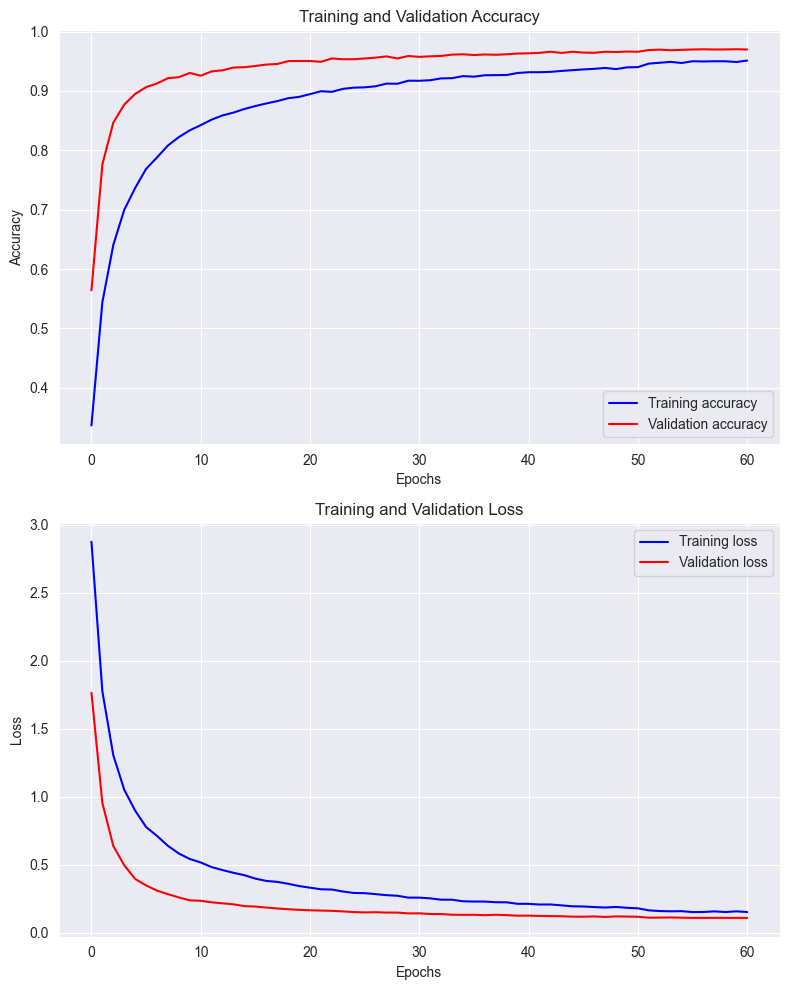

In [24]:
import matplotlib.pyplot as plt

# Check if `history` contains the expected keys
if 'accuracy' in history.history and 'val_accuracy' in history.history and 'loss' in history.history and 'val_loss' in history.history:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(8, 10))

    # Plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid lines

    # Plot training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid lines

    plt.tight_layout()
    plt.show()
else:
    print("Error: `history` object does not contain required keys.")


In [27]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

340/340 [==============================] - 43s 124ms/step
The first 10 predictions: ['giraffe', 'dog', 'lion', 'cat', 'vicuna', 'cat', 'walrus', 'tapir', 'elephant', 'horse']


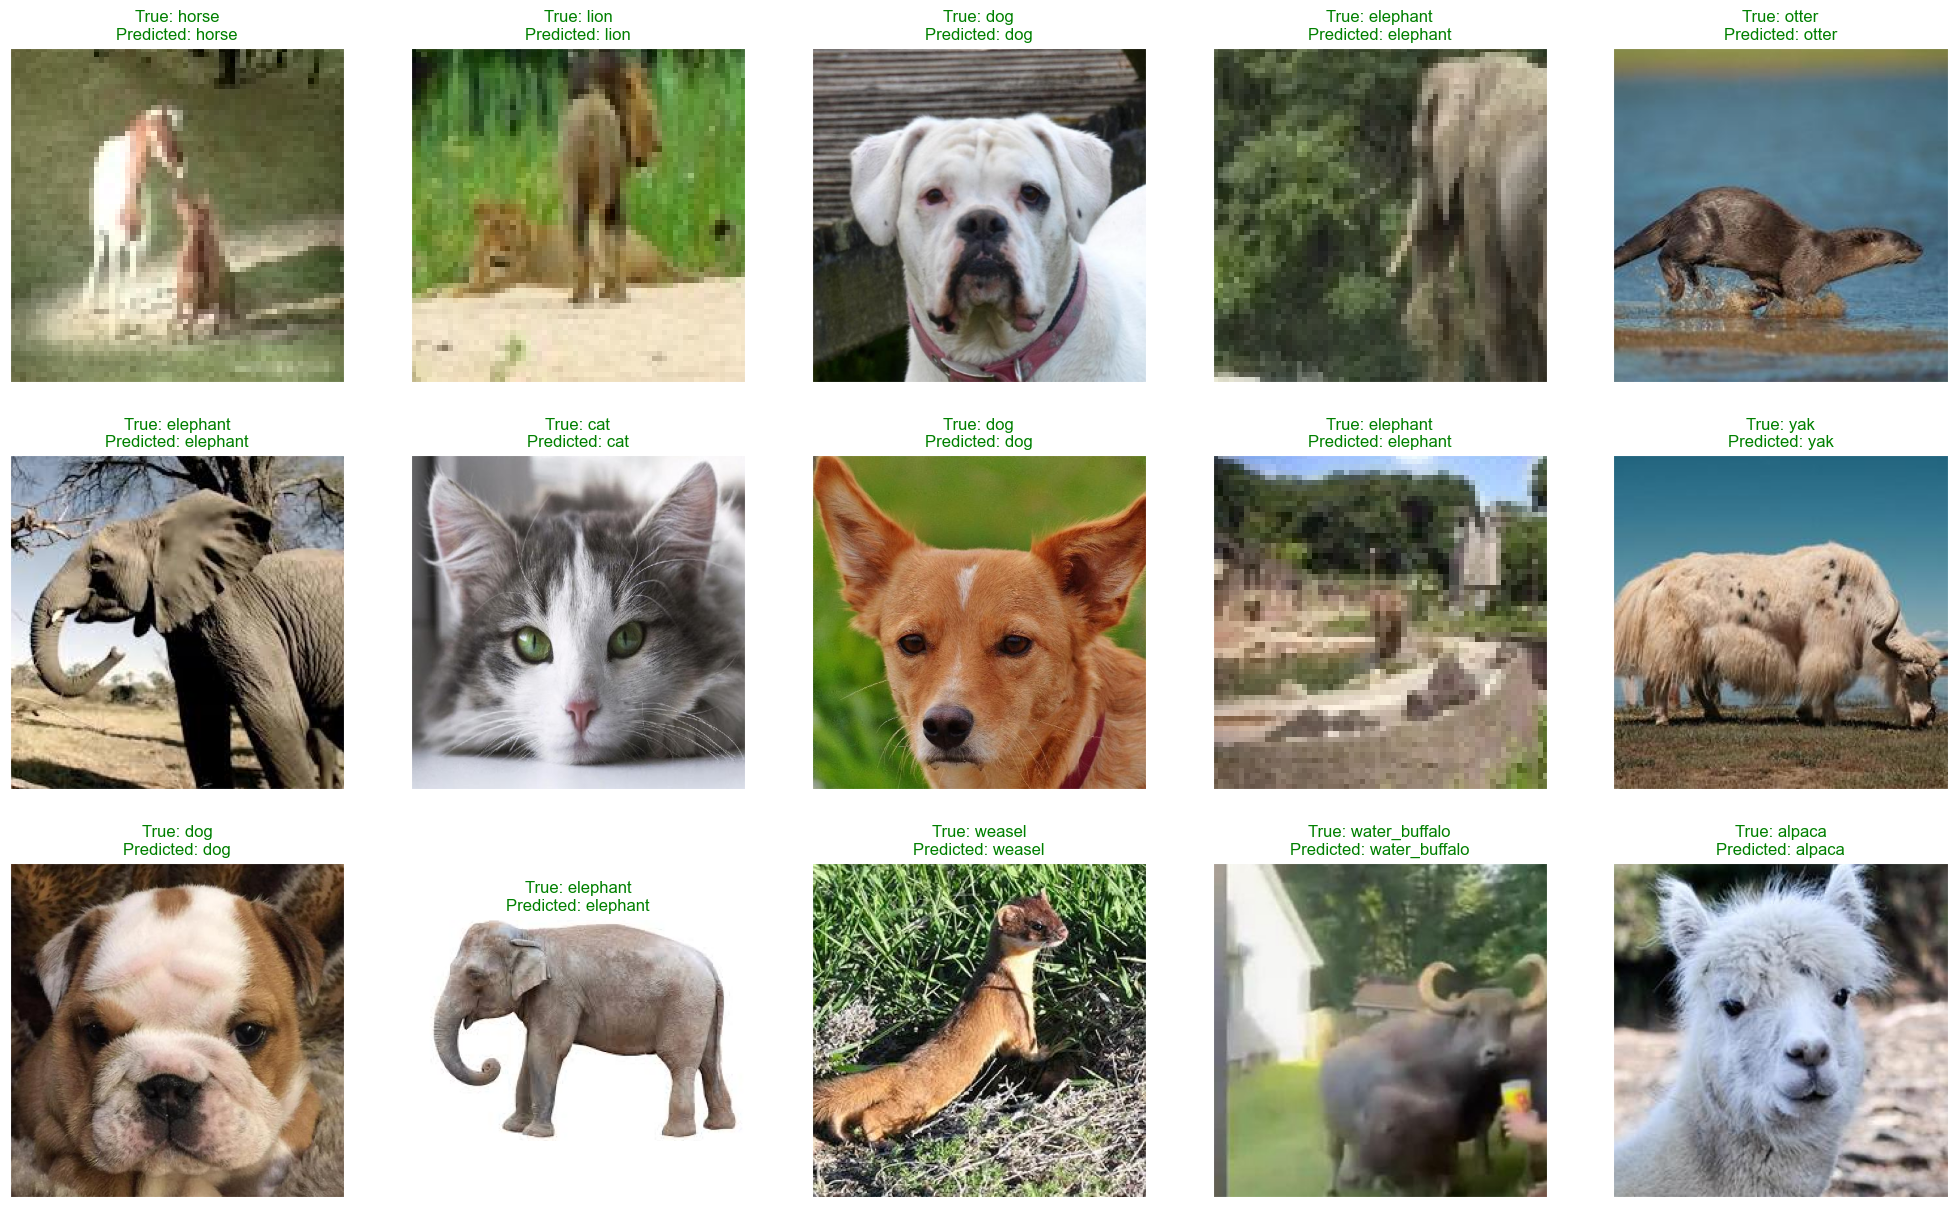

<Figure size 640x480 with 0 Axes>

In [28]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [29]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

african_elephant       0.87      0.90      0.89       133
          alpaca       0.96      0.94      0.95       142
  american_bison       0.99      0.96      0.98       127
        anteater       0.98      0.98      0.98       110
      arctic_fox       0.98      0.93      0.95       128
       armadillo       1.00      0.97      0.98       133
          baboon       0.96      0.98      0.97       131
          badger       1.00      0.93      0.96       124
      blue_whale       0.94      0.94      0.94        93
      brown_bear       0.96      0.99      0.97       138
           camel       0.97      0.94      0.96       102
             cat       1.00      1.00      1.00      1120
             dog       1.00      1.00      1.00      1085
         dolphin       0.92      0.95      0.93       129
        elephant       0.94      0.95      0.95      1027
         giraffe       0.99      1.00      0.99       143
       ground

In [30]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score       support
african_elephant   0.869565  0.902256  0.885609    133.000000
alpaca             0.963768  0.936620  0.950000    142.000000
american_bison     0.991870  0.960630  0.976000    127.000000
anteater           0.981818  0.981818  0.981818    110.000000
arctic_fox         0.975410  0.929688  0.952000    128.000000
armadillo          1.000000  0.969925  0.984733    133.000000
baboon             0.955556  0.984733  0.969925    131.000000
badger             1.000000  0.927419  0.962343    124.000000
blue_whale         0.935484  0.935484  0.935484     93.000000
brown_bear         0.957746  0.985507  0.971429    138.000000
camel              0.969697  0.941176  0.955224    102.000000
cat                1.000000  1.000000  1.000000   1120.000000
dog                0.997243  1.000000  0.998619   1085.000000
dolphin            0.924242  0.945736  0.934866    129.000000
elephant           0.939481  0.952288  0.945841   1027.000000
giraffe            0.986207  1.000000  0.993056    143.000000
groundhog          0.950000  1.000000  0.974359    114.000000
highland_cattle    0.984000  0.968504  0.976190    127.000000
horse              0.972033  0.976462  0.974242   1317.000000
jackal             0.932039  0.979592  0.955224     98.000000
kangaroo           0.970803  0.970803  0.970803    137.000000
koala              0.981982  1.000000  0.990909    109.000000
lion               0.973510  0.951896  0.962582   1081.000000
manatee            0.964539  0.985507  0.974910    138.000000
mongoose           0.942857  0.942857  0.942857    105.000000
mountain_goat      0.985075  0.985075  0.985075    134.000000
opossum            0.984496  0.969466  0.976923    131.000000
orangutan          1.000000  1.000000  1.000000    117.000000
otter              0.918605  0.963415  0.940476     82.000000
polar_bear         0.985714  0.965035  0.975265    143.000000
porcupine          0.992188  1.000000  0.996078    127.000000
red_panda          0.984615  0.969697  0.977099    132.000000
rhinoceros         0.991071  0.965217  0.977974    115.000000
sea_lion           0.884615  0.951724  0.916944    145.000000
seal               0.916667  0.798387  0.853448    124.000000
snow_leopard       0.992366  1.000000  0.996169    130.000000
squirrel           0.963235  0.942446  0.952727    139.000000
sugar_glider       0.976471  0.943182  0.959538     88.000000
tapir              0.983607  0.960000  0.971660    125.000000
vampire_bat        0.956044  0.966667  0.961326     90.000000
vicuna             0.977011  0.955056  0.965909     89.000000
walrus             0.941176  0.991150  0.965517    113.000000
warthog            0.932039  1.000000  0.964824     96.000000
water_buffalo      0.928571  0.915493  0.921986     71.000000
weasel             0.917355  0.973684  0.944681    114.000000
wildebeest         0.982906  0.966387  0.974576    119.000000
wombat             0.992248  0.962406  0.977099    133.000000
yak                0.893617  0.913043  0.903226     92.000000
zebra              0.965812  0.991228  0.978355    114.000000
accuracy           0.969504  0.969504  0.969504      0.969504
macro avg          0.962558  0.962809  0.962365  10854.000000
weighted avg       0.969824  0.969504  0.969478  10854.000000

In [31]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array) # Using grad_model here
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # ... (rest of your function) # Assign class_channel here
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # ... (rest of the function)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  
    superimposed_img.save(cam_path)

 
    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_27264\1371114228.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


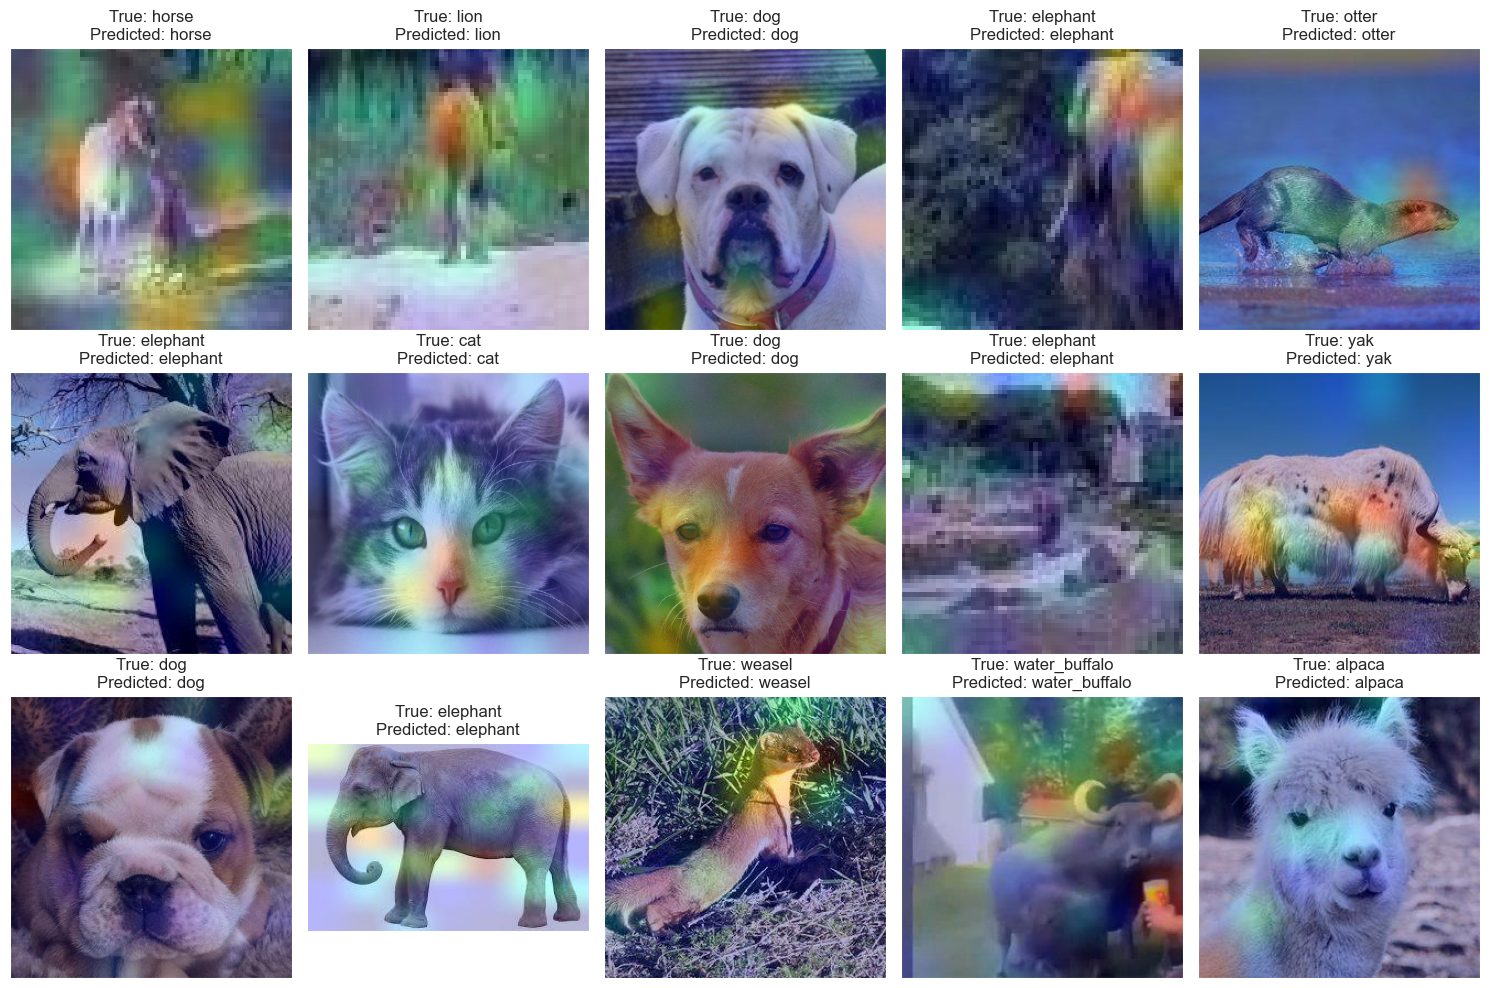

In [34]:
# Specify the last convolutional layer name
last_conv_layer_name = 'conv5_block16_1_relu'  # You can change this to another layer if needed

# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()
